In [18]:
import gc
import os
import sys
import yaml
import glob
import numpy as np
import pickle
import tensorflow as tf
import random

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from spektral.datasets import delaunay
from spektral.layers import *
from spektral.utils.convolution import localpooling_filter
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tqdm.contrib.concurrent import process_map, thread_map

%matplotlib inline

#tf.debugging.set_log_device_placement(True)

# Extracting Representation from CCPE Data

In [4]:
data_directory = './data/ccpe-dados/cfg.llvm'
files = glob.glob(f'{data_directory}/**/*.yaml', recursive=True)
print(f"Found {len(files)} files in {data_directory}")

Found 29990 files in ./data/ccpe-dados/cfg.llvm


In [3]:
"""
output_directory = './data/ccpe-dados/'
output_file = os.path.join(output_directory, 'cfg.llvm_description.yaml')

def get_number_of_nodes(filename: str) -> tuple:
    with open(filename, 'rt') as f:
        try:
            x = yaml.safe_load(f)
            return (filename, len(x['nodes']))
        except yaml.YAMLError as e:
            print(f"Error with file {filename}: {e}")
            return (filename, 0)
        except KeyError as e:
            print(f"Error with file {filename}. Key {e} does not exists")
            return (filename, 0)

results = process_map(get_number_of_nodes, files, max_workers=4, desc='Files read')
results = dict(results)
print(f"Read {len(results)} files")


with open(output_file, 'wt') as f:
    yaml.dump(results, f)
    print(f"Results dumped to {output_file}")
"""
    

Files read:   0%|          | 0/29990 [00:00<?, ?it/s]

Read 29990 files


Graph statistics from 29990 applications:
    Min value: 2
    Max value: 26127
    Average: 742.42990996999
    Stdev: 2327.2399841701613
    Mean: 742.42990996999
    25th percentile: 42.0
    Median: 98.0
    75th percentile: 460.0
    95th percentile: 3635.199999999997



(array([2.7191e+04, 1.0200e+03, 3.3900e+02, 3.4500e+02, 3.6500e+02,
        1.3200e+02, 5.0000e+01, 3.1000e+01, 4.1000e+01, 4.2000e+01,
        1.2200e+02, 8.6000e+01, 3.9000e+01, 6.8000e+01, 4.6000e+01,
        3.1000e+01, 1.7000e+01, 1.3000e+01, 7.0000e+00, 5.0000e+00]),
 array([2.000000e+00, 1.308250e+03, 2.614500e+03, 3.920750e+03,
        5.227000e+03, 6.533250e+03, 7.839500e+03, 9.145750e+03,
        1.045200e+04, 1.175825e+04, 1.306450e+04, 1.437075e+04,
        1.567700e+04, 1.698325e+04, 1.828950e+04, 1.959575e+04,
        2.090200e+04, 2.220825e+04, 2.351450e+04, 2.482075e+04,
        2.612700e+04]),
 <BarContainer object of 20 artists>)

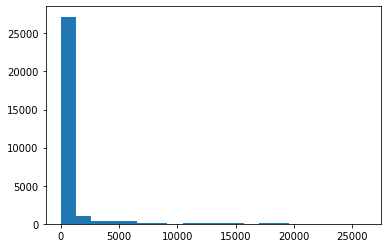

In [14]:
graph_shapes_file = './data/ccpe-dados/cfg.llvm_description.yaml'

with open(output_file, 'rt') as f:
    graph_shapes = yaml.safe_load(f)

graphs_nodes_num = sorted([number_of_nodes for benchmark_name, number_of_nodes in graph_shapes.items()])
print(f"""Graph statistics from {len(graphs_nodes_num)} applications:
    Min value: {min(graphs_nodes_num)}
    Max value: {max(graphs_nodes_num)}
    Average: {np.average(graphs_nodes_num)}
    Stdev: {np.std(graphs_nodes_num)}
    Mean: {np.mean(graphs_nodes_num)}
    25th percentile: {np.percentile(graphs_nodes_num, 25)}
    Median: {np.median(graphs_nodes_num)}
    75th percentile: {np.percentile(graphs_nodes_num, 75)}
    95th percentile: {np.percentile(graphs_nodes_num, 95)}
""")
plt.hist(graphs_nodes_num, 20)


In [25]:
network_input_graph_shape = (150, 150)
network_input_features_shape = (100, 67)


#def resize(matrix: np.array, target_shape: tuple) -> np.array:
#    assert matrix.shape[0] <= target_shape[0] and matrix.shape[1] <= target_shape[1], f"Matrix shape (shape={matrix.shape}) is higher than target shape (shape={target_shape})"
#
#    z = np.zeros(target_shape)
#    z[:matrix.shape[0], :matrix.shape[1]] = matrix
#    return z

graph_shapes_filtered = dict(filter(lambda element: element[1] <= network_input_graph_shape[0], graph_shapes.items()))
print(f"Number of graphs with adjacency matrix below shape {network_input_graph_shape}: {len(graph_shapes_filtered)} ({len(graph_shapes_filtered)/len(graph_shapes)*100}%)")


Number of graphs with adjacency matrix below shape (150, 150): 17853 (59.5298432810937%)


In [37]:
no_train_samples = 10
no_validation_samples = 2
no_test_samples = 2

train_graph_files = random.sample(list(graph_shapes_filtered), no_train_samples)
print(f"Selected {len(train_graph_files)} as training samples")
validation_graph_files = random.sample(list(graph_shapes_filtered), no_validation_samples)
print(f"Selected {len(validation_graph_files)} as validation samples")
test_graph_files = random.sample(list(graph_shapes_filtered), no_test_samples)
print(f"Selected {len(test_graph_files)} as test samples")
print('--------')

def load_graph_from_file(filename: str, target_shape: tuple) -> np.matrix:
    with open(filename, 'rt') as f:
        x = yaml.safe_load(f)
    
    graph = np.zeros(target_shape)
    for node, nodes_list in x['nodes'].items():
        for n in nodes_list:
            graph[node][n] = 1
    return graph

train_graphs = np.array([load_graph_from_file(filename, network_input_graph_shape) for filename in train_graph_files])
print(f"Loaded {len(train_graphs)} graphs as training samples.")
validation_graphs = np.array([load_graph_from_file(filename, network_input_graph_shape) for filename in validation_graph_files])
print(f"Loaded {len(validation_graphs)} graphs as validation samples.")
test_graphs = np.array([load_graph_from_file(filename, network_input_graph_shape) for filename in test_graph_files])
print(f"Loaded {len(test_graphs)} graphs as test samples.")
print('--------')

train_graphs = train_graphs.reshape((no_train_samples//2, 2, network_input_graph_shape[0], network_input_graph_shape[1]))
print(f"Train graphs input shape={train_graphs.shape}")
validation_graphs = validation_graphs.reshape((no_validation_samples//2, 2, network_input_graph_shape[0], network_input_graph_shape[1]))
print(f"Validation graphs input shape={validation_graphs.shape}")
test_graphs = test_graphs.reshape((no_test_samples//2, 2, network_input_graph_shape[0], network_input_graph_shape[1]))
print(f"Test graphs input shape={test_graphs.shape}")


Selected 10 as training samples
Selected 2 as validation samples
Selected 2 as test samples
--------
Loaded 10 graphs as training samples.
Loaded 2 graphs as validation samples.
Loaded 2 graphs as test samples.
--------
Train graphs input shape=(5, 2, 150, 150)
Validation graphs input shape=(1, 2, 150, 150)
Test graphs input shape=(1, 2, 150, 150)


In [ ]:
# Load Features
# ...

In [ ]:
# Defining some parameters for training
N = train_graphs.shape[-2]      # Number of nodes in the graphs
#F = features.shape[-1]          # Original feature dimensionality
#n_classes = y_c.shape[-1]-1     # Number of classes
epochs = 500                    # Number of training epochs
batch_size = 16                 # Batch size
learning_rate = 1e-2            # Learning rate

In [ ]:
# Model definition
conv   = GraphConv(45,activation='relu',use_bias=False)
mincut = MinCutPool(N // 2)
conv2  = GraphConv(55,activation='relu',use_bias=False)
pool   = GlobalAttnSumPool()

# First Graph Layers
X1_in = Input(shape=(N, F))
A1_in = Input((N, N))
gc2_1 = conv([X1_in, A1_in])
gc2_1, A1 = mincut([gc2_1,A1_in])
gc2_1 = conv2([gc2_1, A1])
pool_1 =  pool(gc2_1)
d1 = Dense(200,activation='relu')(pool_1)

# Second Graph Layers
X2_in = Input(shape=(N, F))
A2_in = Input((N, N))
gc2_2 = conv([X2_in, A2_in]) # Notice that both graphs shares layers (shared weights)
gc2_2, A2 = mincut([gc2_2,A2_in])
gc2_2 = conv2([gc2_2, A2])
pool_2 = pool(gc2_2)
d2 = Dense(200,activation='relu')(pool_2)

# Dense final layers
merged = Concatenate()([d1, d2])

merged1 = Dense(800,activation='relu')(merged)
merged2 = Dense(32,activation='relu')(merged1)

classe = Dense(n_classes, name="class",activation="softmax")(merged2)
speedup = Dense(1, name="speddup")(merged2)

# Build model
model = Model(inputs=[X1_in, A1_in,X2_in, A2_in], outputs=[classe,speedup])
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss=['categorical_crossentropy', 'mse'],loss_weights=[1, 0.00005], weighted_metrics=['acc'])
model.summary()

In [ ]:
# Train model
fltr1 = A_train[:,0,:,:]
fltr2 = A_train[:,1,:,:]

history = model.fit([x_train[:,0,:,:],fltr1, x_train[:,1,:,:], fltr2],
        [y_train[:,0:4],y_train[:,4]],
          batch_size=batch_size,
          validation_split=0.05,
          epochs=epochs)

plt.plot(np.array(history.history['class_acc']))
plt.plot(np.array(history.history['val_class_acc']))
plt.title('model accuracy')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['treino', 'val'], loc='upper left')
plt.savefig("test.pdf")

In [ ]:
# Evaluate model
print('Evaluating model.')
eval_results = model.evaluate([x_test[:,0,:,:], A_test[:,0,:,:], x_test[:,1,:,:], A_test[:,1,:,:]],
        [y_test[:,0:4],y_test[:,4]],
                              batch_size=batch_size)
print('Done. Test loss: {:.4f}. Test acc: {:.2f}'.format(*eval_results))

print("Confusion matrix:")
y_pred = model.predict([x_test[:,0,:,:], A_test[:,0,:,:], x_test[:,1,:,:], A_test[:,1,:,:]])
y_pred = np.argmax(y_pred[0], axis=-1)
y_test = np.argmax(y_test[:,0:4], axis=-1)

cm=confusion_matrix(y_test,y_pred)
print(cm)